In [ ]:
import speedtest_cli
import subprocess
import time
import statistics
import datetime
import json
from pathlib import Path
import platform

class InternetMonitor:
    def __init__(self, log_file="internet_stats.json", speed_test_interval=300):
        self.log_file = Path(log_file)
        self.speed_test_interval = speed_test_interval
        self.last_speed_test = 0
        self.stats = {
            "timestamp": [],
            "download_speed": [],
            "upload_speed": [],
            "ping": [],
            "packet_loss": [],
            "jitter": []
        }
        
    def measure_speed(self):
        """Measure download and upload speeds"""
        current_time = time.time()
        
        if (current_time - self.last_speed_test) < self.speed_test_interval:
            if self.stats["download_speed"] and self.stats["upload_speed"]:
                return (self.stats["download_speed"][-1], 
                        self.stats["upload_speed"][-1])
            return None, None
            
        try:
            st = speedtest_cli.Speedtest()
            download = st.download() / 1_000_000  # Convert to Mbps
            upload = st.upload() / 1_000_000      # Convert to Mbps
            self.last_speed_test = current_time
            return download, upload
        except Exception as e:
            print(f"Speed test failed: {e}")
            return None, None

    def ping_command(self, host="8.8.8.8", count=3):
        """Use system ping command instead of ping3"""
        system = platform.system().lower()
        
        try:
            if system == "windows":
                cmd = ["ping", "-n", str(count), host]
            else:  # Linux or MacOS
                cmd = ["ping", "-c", str(count), host]
            
            result = subprocess.run(cmd, capture_output=True, text=True)
            
            if result.returncode == 0:
                # Parse the ping output
                output = result.stdout
                if system == "windows":
                    # Parse Windows ping output
                    times = [float(line.split("time=")[1].split("ms")[0].strip()) 
                            for line in output.splitlines() 
                            if "time=" in line]
                else:
                    # Parse Linux/MacOS ping output
                    times = [float(line.split("time=")[1].split(" ")[0]) 
                            for line in output.splitlines() 
                            if "time=" in line]
                
                if times:
                    avg_ping = statistics.mean(times)
                    jitter = statistics.stdev(times) if len(times) > 1 else 0
                    packet_loss = 100 - (len(times) / count * 100)
                    return avg_ping, jitter, packet_loss
            
            return None, None, 100
            
        except Exception as e:
            print(f"Ping failed: {e}")
            return None, None, 100

    def collect_metrics(self):
        """Collect all metrics and store them"""
        timestamp = datetime.datetime.now().isoformat()
        download, upload = self.measure_speed()
        ping, jitter, packet_loss = self.ping_command()

        self.stats["timestamp"].append(timestamp)
        self.stats["download_speed"].append(download)
        self.stats["upload_speed"].append(upload)
        self.stats["ping"].append(ping)
        self.stats["jitter"].append(jitter)
        self.stats["packet_loss"].append(packet_loss)

    def save_stats(self):
        """Save stats to JSON file"""
        with open(self.log_file, 'w') as f:
            json.dump(self.stats, f, indent=2)

    def print_latest_stats(self):
        """Print the most recent measurements"""
        if not self.stats["timestamp"]:
            print("No measurements available")
            return

        i = -1  # Index of latest measurement
        print("\n=== Latest Internet Connection Stats ===")
        print(f"Timestamp: {self.stats['timestamp'][i]}")
        if self.stats['download_speed'][i] is not None:
            print(f"Download Speed: {self.stats['download_speed'][i]:.2f} Mbps")
            print(f"Upload Speed: {self.stats['upload_speed'][i]:.2f} Mbps")
        else:
            print("Speed test pending...")
        
        if self.stats['ping'][i] is not None:
            print(f"Ping: {self.stats['ping'][i]:.2f} ms")
            print(f"Jitter: {self.stats['jitter'][i]:.2f} ms")
            print(f"Packet Loss: {self.stats['packet_loss'][i]:.2f}%")
        else:
            print("Ping measurement failed")

def main():
    monitor = InternetMonitor(speed_test_interval=300)
    
    try:
        while True:
            print("\nCollecting metrics...")
            monitor.collect_metrics()
            monitor.print_latest_stats()
            monitor.save_stats()
            
            time.sleep(1)
            
    except KeyboardInterrupt:
        print("\nMonitoring stopped by user")
        monitor.save_stats()

if __name__ == "__main__":
    main()


Speed test failed: module 'speedtest' has no attribute 'Speedtest'


PermissionError: [Errno 13] Permission denied

In [ ]:
import time
import subprocess
import pandas as pd
import os
import sys

def get_ping():
    result = subprocess.run(['ping', '-c', '1', '8.8.8.8'], capture_output=True, text=True)
    output = result.stdout
    if 'time=' in output:
        try:
            latency = float(output.split('time=')[1].split(' ')[0])
            return latency
        except Exception:
            return None
    return None

def log_internet_stats(file_path='internet_logs.parquet', interval=1, save_every=100):
    logs = []
    start_time = time.strftime('%Y-%m-%d %H:%M:%S')
    
    if os.path.exists(file_path):
        df_existing = pd.read_parquet(file_path)
        logs = df_existing.to_dict('records')
    else:
        df = pd.DataFrame(columns=['timestamp', 'latency'])
        df.to_parquet(file_path, index=False)
    
    try:
        while True:
            timestamp = time.strftime('%Y-%m-%d %H:%M:%S')
            latency = get_ping()
            download, upload = get_speed()
            logs.append({'timestamp': timestamp, 'latency': latency, 'download_mbps': download, 'upload_mbps': upload})
            
            if len(logs) >= save_every:
                df = pd.DataFrame(logs)
                df.to_parquet(file_path, index=False)
                logs = []
            
            sys.stdout.write(f"\rLogging started at {start_time}. Logs saved so far: {len(pd.read_parquet(file_path))}")
            sys.stdout.flush()
            
            time.sleep(interval)
    except KeyboardInterrupt:
        if logs:
            df = pd.DataFrame(logs)
            df.to_parquet(file_path, index=False)
        print("\nLogging stopped.")

log_internet_stats()

Speedtest failed.
Logging started at 2025-02-17 18:08:03. Logs saved so far: 33

Speedtest failed.
Logging started at 2025-02-17 18:08:03. Logs saved so far: 33Speedtest failed.
Logging started at 2025-02-17 18:08:03. Logs saved so far: 33Speedtest failed.
Logging started at 2025-02-17 18:08:03. Logs saved so far: 33Speedtest failed.
Logging started at 2025-02-17 18:08:03. Logs saved so far: 33Speedtest failed.
Logging started at 2025-02-17 18:08:03. Logs saved so far: 33Speedtest failed.
Logging started at 2025-02-17 18:08:03. Logs saved so far: 33
Logging stopped.


Latency Statistics:
count     33.000000
mean      40.806061
std       34.556023
min       20.700000
25%       23.500000
50%       26.800000
75%       44.300000
max      195.000000
Name: latency, dtype: float64

Download Speed Statistics:
count       0
unique      0
top       NaN
freq      NaN
Name: download_mbps, dtype: object

Upload Speed Statistics:
count       0
unique      0
top       NaN
freq      NaN
Name: upload_mbps, dtype: object


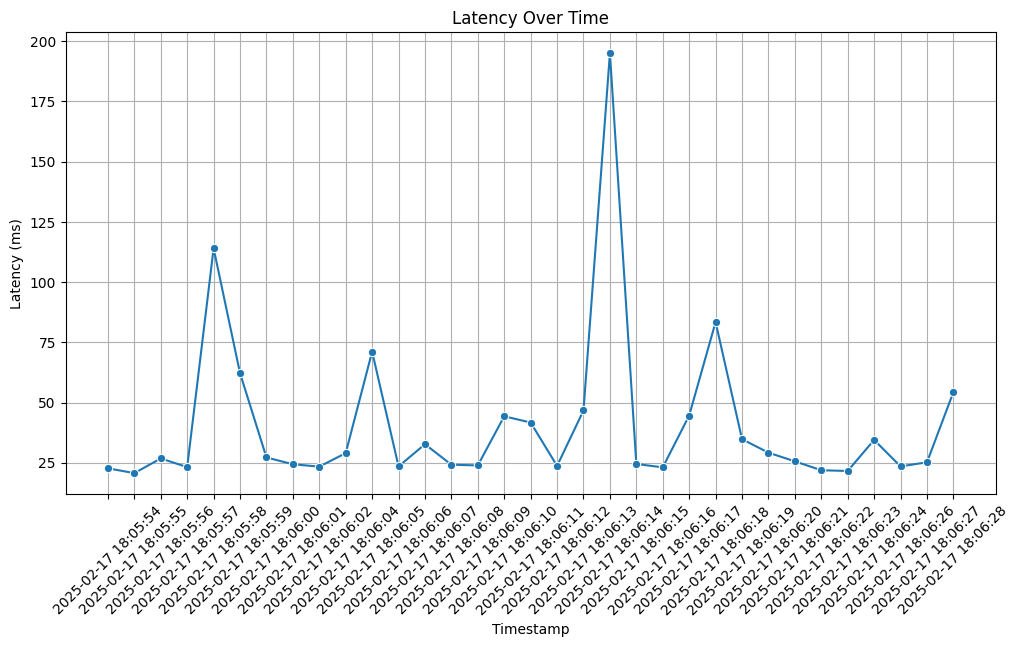

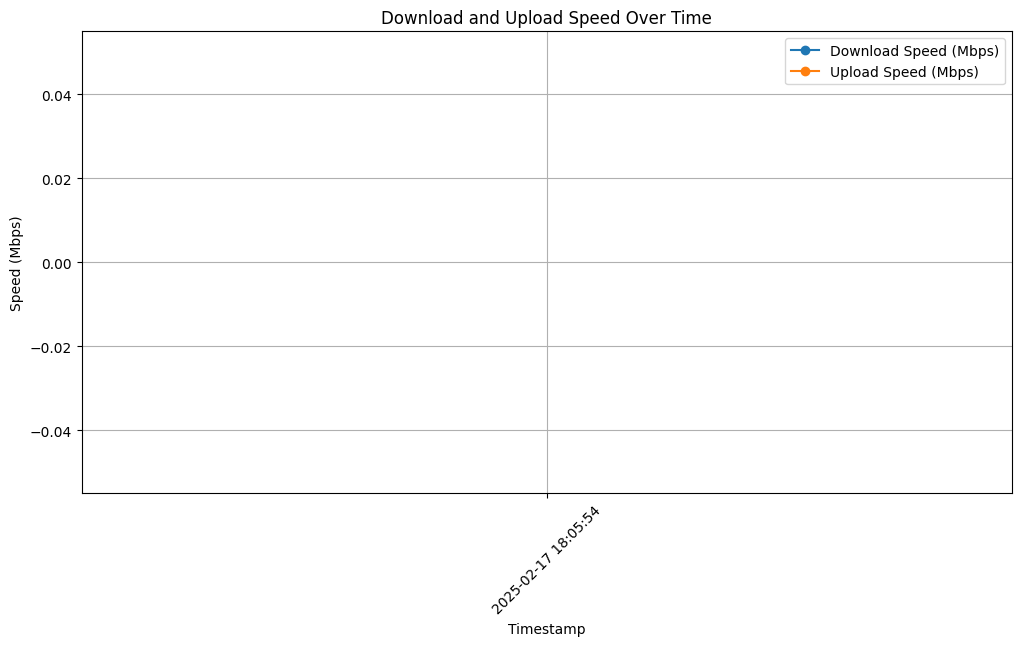

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def load_data(file_path='internet_logs.parquet'):
    return pd.read_parquet(file_path)

def plot_latency(df):
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=df['timestamp'], y=df['latency'], marker='o')
    plt.title('Latency Over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Latency (ms)')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

def plot_speed(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df['timestamp'], df['download_mbps'], label='Download Speed (Mbps)', marker='o')
    plt.plot(df['timestamp'], df['upload_mbps'], label='Upload Speed (Mbps)', marker='o')
    plt.title('Download and Upload Speed Over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Speed (Mbps)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.show()

def summarize_stats(df):
    print("Latency Statistics:")
    print(df['latency'].describe())
    print("\nDownload Speed Statistics:")
    print(df['download_mbps'].describe())
    print("\nUpload Speed Statistics:")
    print(df['upload_mbps'].describe())

if __name__ == "__main__":
    df = load_data()
    summarize_stats(df)
    plot_latency(df)
    plot_speed(df)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np

# Load the data
df = pd.read_parquet('internet_stats.parquet')

# Convert timestamp to pandas datetime if not already
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Set timestamp as index
df = df.set_index('timestamp')

# Basic time-based analysis functions
def get_hourly_stats(df):
    """Calculate hourly averages for all metrics"""
    return df.resample('H').mean()

def get_daily_stats(df):
    """Calculate daily averages for all metrics"""
    return df.resample('D').mean()

def get_time_of_day_analysis(df):
    """Analyze metrics by hour of day"""
    df['hour'] = df.index.hour
    hourly_means = df.groupby('hour').mean()
    return hourly_means

def plot_metrics_over_time(df, days=7):
    """Plot all metrics for the last N days"""
    recent_df = df[df.index > (df.index.max() - pd.Timedelta(days=days))]
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Speed plot
    ax1.plot(recent_df.index, recent_df['download_speed'], label='Download')
    ax1.plot(recent_df.index, recent_df['upload_speed'], label='Upload')
    ax1.set_title('Internet Speeds')
    ax1.set_ylabel('Speed (Mbps)')
    ax1.legend()
    
    # Ping plot
    ax2.plot(recent_df.index, recent_df['ping'])
    ax2.set_title('Ping')
    ax2.set_ylabel('ms')
    
    # Jitter plot
    ax3.plot(recent_df.index, recent_df['jitter'])
    ax3.set_title('Jitter')
    ax3.set_ylabel('ms')
    
    # Packet loss plot
    ax4.plot(recent_df.index, recent_df['packet_loss'])
    ax4.set_title('Packet Loss')
    ax4.set_ylabel('%')
    
    plt.tight_layout()
    return fig

def plot_daily_patterns(df):
    """Plot average metrics by hour of day"""
    hourly = get_time_of_day_analysis(df)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Speed patterns
    ax1.plot(hourly.index, hourly['download_speed'], label='Download')
    ax1.plot(hourly.index, hourly['upload_speed'], label='Upload')
    ax1.set_title('Average Speeds by Hour')
    ax1.set_ylabel('Speed (Mbps)')
    ax1.set_xlabel('Hour of Day')
    ax1.legend()
    
    # Ping patterns
    ax2.plot(hourly.index, hourly['ping'])
    ax2.set_title('Average Ping by Hour')
    ax2.set_ylabel('ms')
    ax2.set_xlabel('Hour of Day')
    
    # Jitter patterns
    ax3.plot(hourly.index, hourly['jitter'])
    ax3.set_title('Average Jitter by Hour')
    ax3.set_ylabel('ms')
    ax3.set_xlabel('Hour of Day')
    
    # Packet loss patterns
    ax4.plot(hourly.index, hourly['packet_loss'])
    ax4.set_title('Average Packet Loss by Hour')
    ax4.set_ylabel('%')
    ax4.set_xlabel('Hour of Day')
    
    plt.tight_layout()
    return fig

def calculate_sla_metrics(df, speed_threshold=None, ping_threshold=None):
    """Calculate SLA-like metrics"""
    total_records = len(df)
    
    metrics = {
        'total_outages': len(df[df['ping'].isnull()]),
        'avg_download': df['download_speed'].mean(),
        'avg_upload': df['upload_speed'].mean(),
        'avg_ping': df['ping'].mean(),
        'avg_packet_loss': df['packet_loss'].mean(),
        '95th_percentile_ping': df['ping'].quantile(0.95),
        'worst_packet_loss': df['packet_loss'].max(),
        'availability': (1 - len(df[df['ping'].isnull()]) / total_records) * 100
    }
    
    if speed_threshold:
        metrics['speed_sla_violations'] = len(df[df['download_speed'] < speed_threshold])
        metrics['speed_sla_compliance'] = (1 - metrics['speed_sla_violations'] / total_records) * 100
        
    if ping_threshold:
        metrics['ping_sla_violations'] = len(df[df['ping'] > ping_threshold])
        metrics['ping_sla_compliance'] = (1 - metrics['ping_sla_violations'] / total_records) * 100
    
    return pd.Series(metrics)

def find_outages(df, duration_minutes=5):
    """Find internet outages lasting longer than specified duration"""
    # Calculate time differences between measurements
    time_diff = df.index.to_series().diff()
    
    # Find gaps larger than the specified duration
    outages = time_diff[time_diff > pd.Timedelta(minutes=duration_minutes)]
    
    return pd.DataFrame({
        'start_time': outages.index - time_diff,
        'end_time': outages.index,
        'duration_minutes': time_diff.dt.total_seconds() / 60
    })

'\n# Basic statistics\nprint("Daily Statistics:")\nprint(get_daily_stats(df))\n\n# Plot recent metrics\nplot_metrics_over_time(df, days=7)\nplt.show()\n\n# Plot daily patterns\nplot_daily_patterns(df)\nplt.show()\n\n# Calculate SLA metrics\nsla = calculate_sla_metrics(df, speed_threshold=50, ping_threshold=100)\nprint("\nSLA Metrics:")\nprint(sla)\n\n# Find outages\noutages = find_outages(df, duration_minutes=5)\nprint("\nOutages:")\nprint(outages)\n'

In [13]:
# Load and inspect recent data
recent_df = df.last('7D')  # Last 7 days
print(recent_df.describe())

# Check peak usage times
daily_patterns = get_time_of_day_analysis(df)
print("Peak usage hour:", daily_patterns['download_speed'].idxmax())

# Calculate SLA metrics for your service level
sla = calculate_sla_metrics(df, speed_threshold=100, ping_threshold=50)
print(sla)

       download_speed  upload_speed        ping  packet_loss      jitter
count          1.0000      1.000000   45.000000         45.0   45.000000
mean          71.1169      4.581015   83.866667          0.0   52.006713
std               NaN           NaN   67.335943          0.0   51.635092
min           71.1169      4.581015   23.400000          0.0    1.081665
25%           71.1169      4.581015   46.166667          0.0   14.838239
50%           71.1169      4.581015   66.933333          0.0   32.051573
75%           71.1169      4.581015   96.866667          0.0   78.371700
max           71.1169      4.581015  429.333333          0.0  252.668426
Peak usage hour: 18
total_outages             0.000000
avg_download             71.116900
avg_upload                4.581015
avg_ping                 83.866667
avg_packet_loss           0.000000
95th_percentile_ping    167.080000
worst_packet_loss         0.000000
availability            100.000000
speed_sla_violations      1.000000
speed_sl

/tmp/ipykernel_3511/1545507098.py:2: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_df = df.last('7D')  # Last 7 days


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np
import calendar

def create_speed_heatmap(df):
    """Create a heatmap of internet speeds by hour and day of week"""
    # Add hour and day of week columns
    df_copy = df.copy()
    df_copy['hour'] = df_copy.index.hour
    df_copy['day_of_week'] = df_copy.index.day_name()
    
    # Create pivot tables for download and upload speeds
    pivot_download = df_copy.pivot_table(
        values='download_speed', 
        index='hour',
        columns='day_of_week',
        aggfunc='mean'
    )
    
    # Reorder days of week
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    pivot_download = pivot_download[days_order]
    
    # Create the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_download, 
                cmap='YlOrRd', 
                annot=True, 
                fmt='.1f',
                cbar_kws={'label': 'Mbps'})
    plt.title('Average Download Speed by Hour and Day of Week')
    plt.ylabel('Hour of Day')
    plt.xlabel('Day of Week')
    return plt.gcf()

def plot_speed_distribution(df):
    """Create distribution plots for download and upload speeds"""
    plt.figure(figsize=(15, 5))
    
    # Download speed distribution
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x='download_speed', bins=30, kde=True)
    plt.title('Distribution of Download Speeds')
    plt.xlabel('Speed (Mbps)')
    
    # Upload speed distribution
    plt.subplot(1, 2, 2)
    sns.histplot(data=df, x='upload_speed', bins=30, kde=True)
    plt.title('Distribution of Upload Speeds')
    plt.xlabel('Speed (Mbps)')
    
    plt.tight_layout()
    return plt.gcf()

def plot_latency_metrics(df):
    """Plot ping and jitter over time with rolling averages"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot ping
    ax1.plot(df.index, df['ping'], alpha=0.3, label='Raw', color='blue')
    ax1.plot(df.index, df['ping'].rolling(window=60).mean(), 
             label='1 Hour Moving Average', color='red')
    ax1.set_title('Ping Over Time')
    ax1.set_ylabel('Ping (ms)')
    ax1.legend()
    
    # Plot jitter
    ax2.plot(df.index, df['jitter'], alpha=0.3, label='Raw', color='blue')
    ax2.plot(df.index, df['jitter'].rolling(window=60).mean(), 
             label='1 Hour Moving Average', color='red')
    ax2.set_title('Jitter Over Time')
    ax2.set_ylabel('Jitter (ms)')
    ax2.legend()
    
    plt.tight_layout()
    return fig

def create_performance_dashboard(df, days=7):
    """Create a comprehensive dashboard of internet performance"""
    recent_df = df[df.index > (df.index.max() - pd.Timedelta(days=days))]
    
    fig = plt.figure(figsize=(15, 12))
    gs = fig.add_gridspec(3, 2)
    
    # Speed over time
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(recent_df.index, recent_df['download_speed'], label='Download')
    ax1.plot(recent_df.index, recent_df['upload_speed'], label='Upload')
    ax1.set_title('Internet Speeds')
    ax1.set_ylabel('Speed (Mbps)')
    ax1.legend()
    
    # Ping distribution
    ax2 = fig.add_subplot(gs[1, 0])
    sns.boxplot(data=recent_df, y='ping', ax=ax2)
    ax2.set_title('Ping Distribution')
    ax2.set_ylabel('Ping (ms)')
    
    # Packet loss distribution
    ax3 = fig.add_subplot(gs[1, 1])
    sns.boxplot(data=recent_df, y='packet_loss', ax=ax3)
    ax3.set_title('Packet Loss Distribution')
    ax3.set_ylabel('Packet Loss (%)')
    
    # Daily patterns
    hourly = recent_df.groupby(recent_df.index.hour).mean()
    
    ax4 = fig.add_subplot(gs[2, 0])
    ax4.plot(hourly.index, hourly['download_speed'])
    ax4.set_title('Average Speed by Hour')
    ax4.set_xlabel('Hour of Day')
    ax4.set_ylabel('Speed (Mbps)')
    
    ax5 = fig.add_subplot(gs[2, 1])
    ax5.plot(hourly.index, hourly['ping'])
    ax5.set_title('Average Ping by Hour')
    ax5.set_xlabel('Hour of Day')
    ax5.set_ylabel('Ping (ms)')
    
    plt.tight_layout()
    return fig

def plot_quality_metrics(df):
    """Plot quality metrics with thresholds"""
    # Define thresholds
    speed_threshold = df['download_speed'].median() * 0.8  # 80% of median speed
    ping_threshold = df['ping'].median() * 1.2  # 120% of median ping
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Speed compliance
    speed_data = df['download_speed'].fillna(0)
    speed_compliance = (speed_data >= speed_threshold).mean() * 100
    ax1.pie([speed_compliance, 100-speed_compliance], 
            labels=['Compliant', 'Non-compliant'],
            autopct='%1.1f%%',
            colors=['green', 'red'])
    ax1.set_title('Speed Compliance')
    
    # Ping compliance
    ping_data = df['ping'].fillna(1000)
    ping_compliance = (ping_data <= ping_threshold).mean() * 100
    ax2.pie([ping_compliance, 100-ping_compliance],
            labels=['Compliant', 'Non-compliant'],
            autopct='%1.1f%%',
            colors=['green', 'red'])
    ax2.set_title('Ping Compliance')
    
    # Packet loss distribution
    sns.boxplot(data=df, y='packet_loss', ax=ax3)
    ax3.set_title('Packet Loss Distribution')
    ax3.set_ylabel('Packet Loss (%)')
    
    # Availability
    availability = (1 - df['ping'].isnull().mean()) * 100
    ax4.pie([availability, 100-availability],
            labels=['Available', 'Unavailable'],
            autopct='%1.1f%%',
            colors=['green', 'red'])
    ax4.set_title('Service Availability')
    
    plt.tight_layout()
    return fig

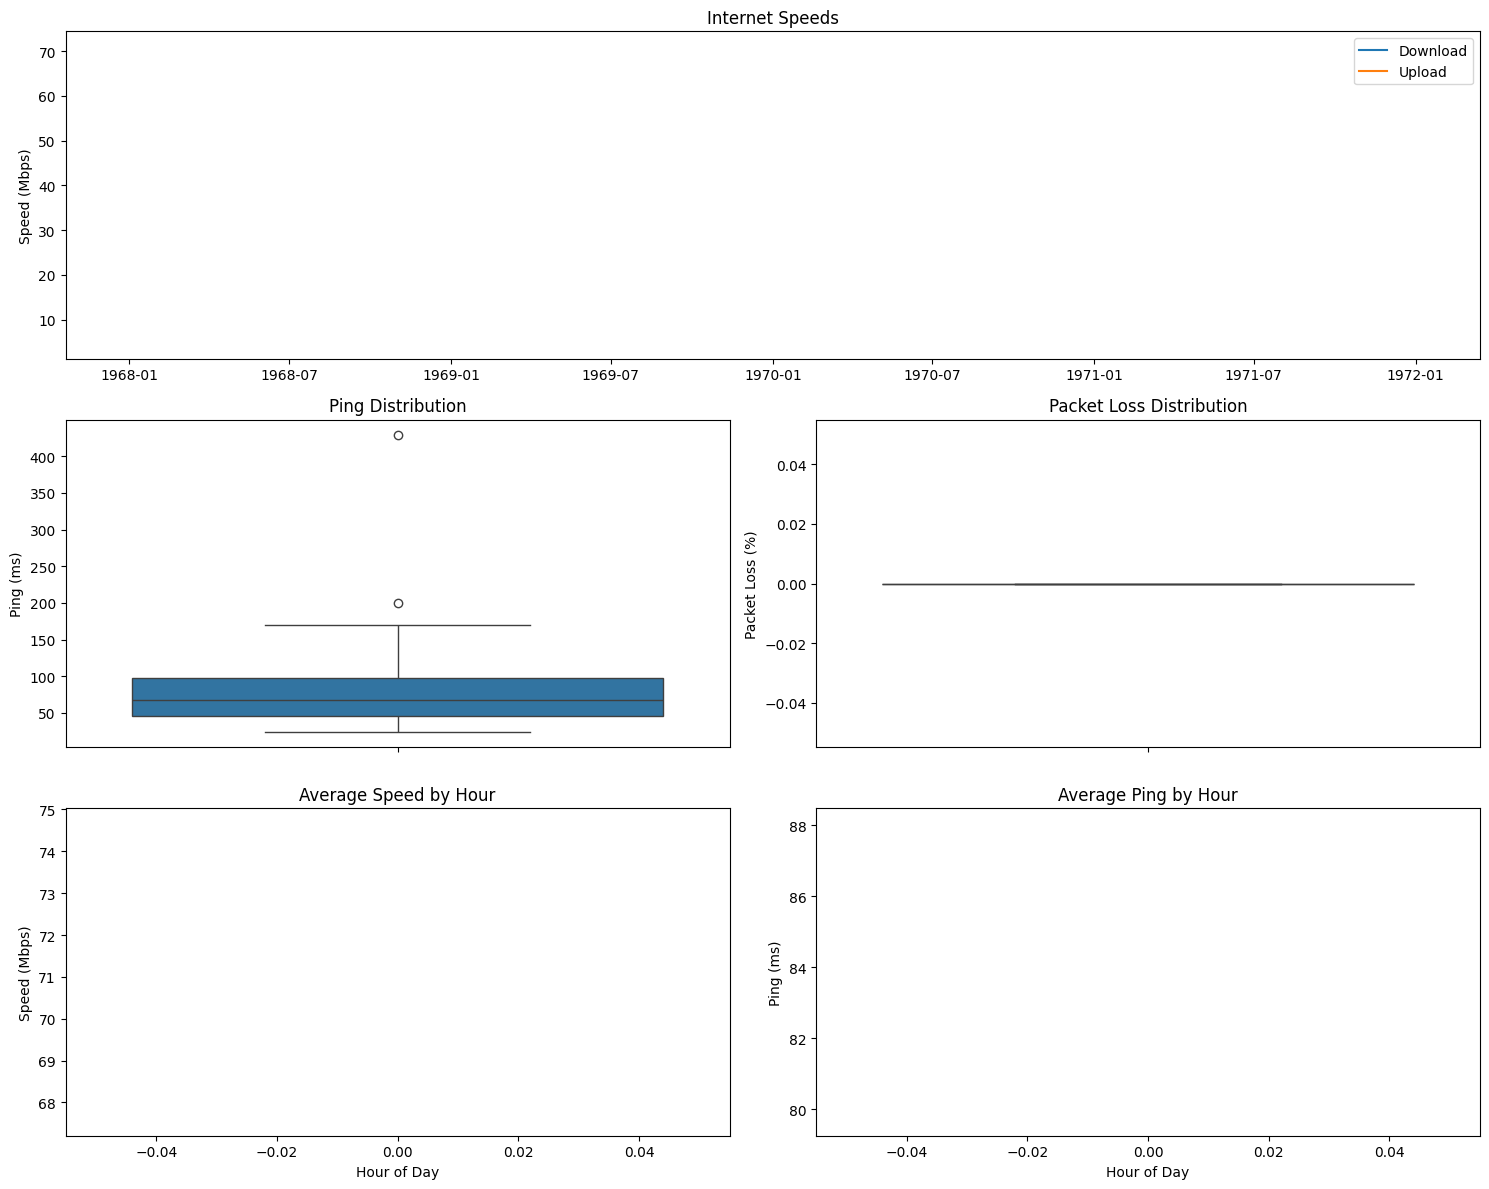

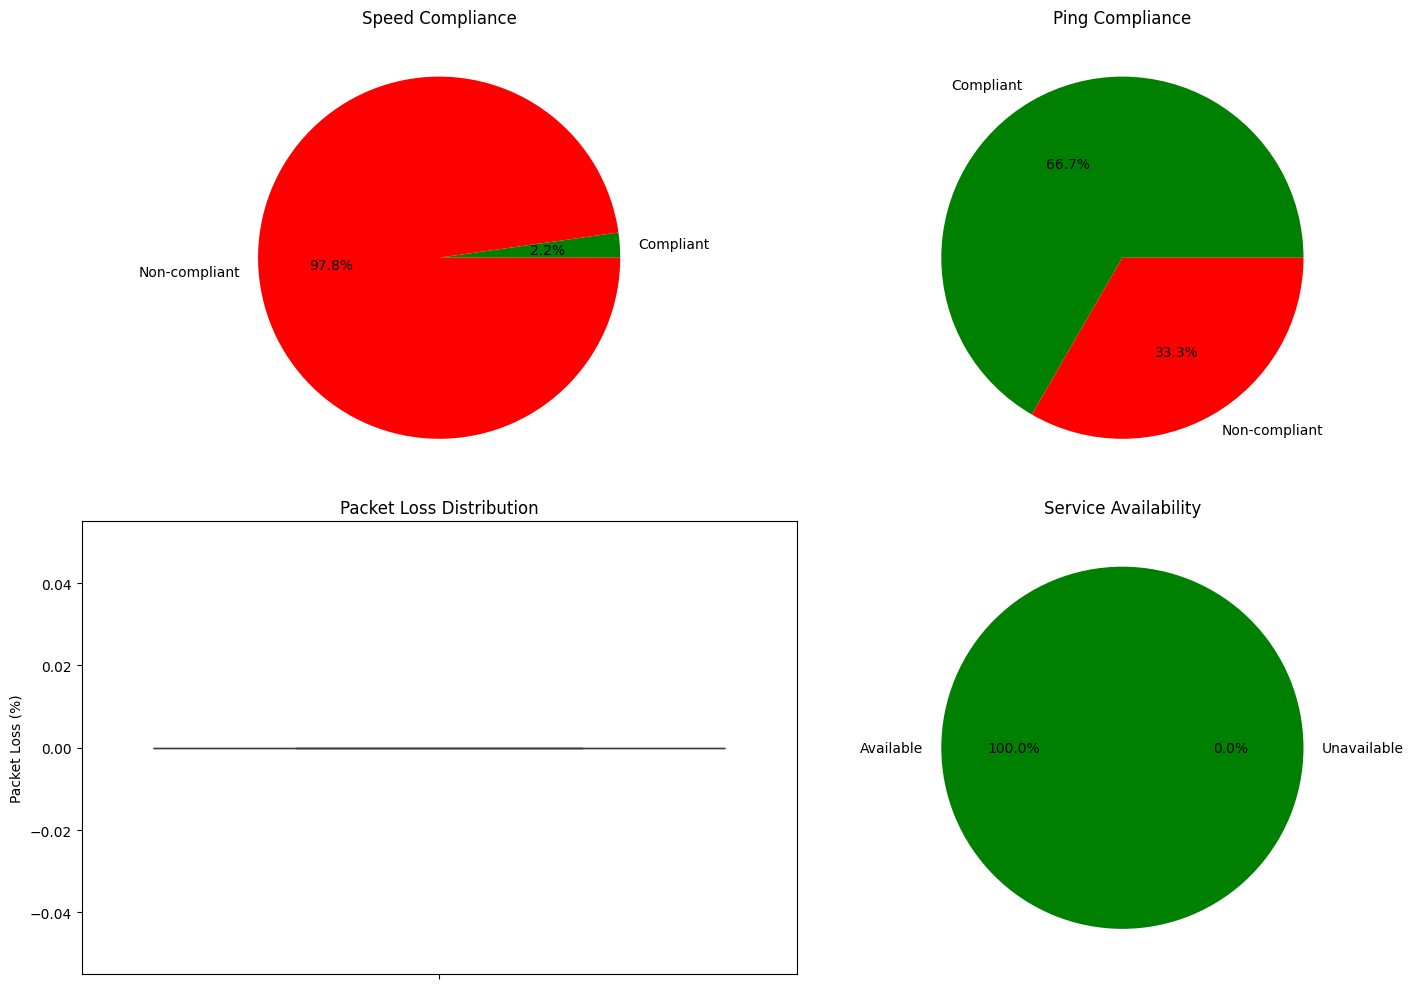

In [16]:
import matplotlib.pyplot as plt

# Load your data
df = pd.read_parquet('internet_stats.parquet')
df.index = pd.to_datetime(df.index)


# Create a dashboard
create_performance_dashboard(df, days=7)  # Last 7 days
plt.show()

# Save plots if needed
plot_quality_metrics(df).savefig('quality_metrics.png')